## Scattered data interpolation

This notebook describes and compares several methods of scattered data interpolation.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as optimize
import pygsvd
from sampling import Sampling
from roll_zeropad import roll_zeropad
matplotlib.rcParams['font.size'] = 16

### The problem: inferring an image from a noisy, irregular sampling

Imagine that there is some function defining an image. This function can be in any number of dimensions, but we will use the two-dimensional case for the examples in this notebook. 

Now imagine that the data you have about this image is some sampling of its values at certain locations. However this sampling has several properties, that are common in situations involving real data:

 * The sampling isn't directly of the image, but of the image convolved with some resolution. So each sample is a projection of the image onto the "kernel" defining the resolution. The kernel may be different for each sample.
 * The sampling isn't on a rectilinear grid, and in fact may be of an arbitrarily irregular set of points.
 * The sampling is noisy, in the sense that the values you get from the sampling are the resolution-convolved image samples, plus some random noise term. We will assume that the noise is independent in each sample.

Astronomical data can have all of these properties, found separately or together. First, telescope image has some fundamental resolution that sets the minimal kernel width, and in many applications the atmosphere or the instrument provides an even broader kernel. When combining multiple images, the kernel can vary due to variations in the atmosphere. Some instruments, like the Gaia satellite have gross asymmetries in their kernel, and the asymmetries are aligned differently with respect to the images for different samples. Gravitationally lenses can create very heterogeneous kernels. Second, not all instruments have a rectilinear sampling (particularly integral field spectroscopy), and even when they do, multiple observations with the same instrument do not necessarily align. Gravitational lenses also effectively provide an irregular sampling of the source plane. Third, all of these observations have intrinsic noise, and we want to be able to reliably interpret them even in the noisy regime.

### Example: a point source

The simplest image we can imagine is that there is a point source, or Dirac delta function. In astronomy, this would just be a single star in the image. Although naively one might think this is trivial, restricted example, in fact since the sampling defined above, as well as the methods we describe below, are all linear, the use of a point source as an example leads to no loss of generality. This claim follows from the fact that every function we can imagine can be expressed as a linear sum of delta functions.

Now we will set up a sampling of this delta function, with:

 * Samples randomly distributed within +/- 10 units of distance in each dimension
 * Resolution defined by a Gaussian kernel, with each sample having a randomly chosen standard deviation between 1 and 3 units of distance.
 * Noise that is proportial to the square root of the sample value. 


In [2]:
sampling = Sampling(nsamples=1000)

The plot below shows the sampling (with the size of the points proportional to the width of the kernel.

In [3]:
sampling.set_flux(total_flux=1000., noise=1.e-3)
sampling.imshow()
plt.savefig('../tex/figures/scattered-data.png', dpi=300)

NameError: name 'plt' is not defined

We will reconstruct on a 21 by 21 grid, with the $x$ and $y$ coordinates set below (with coordinate $(0,0)$ at pixel center $(10, 10)$), and pixels space each unit of distance in the space.

In [377]:
nx = 21
ny = 21
xgrid = sampling.xylo + (sampling.xyhi - sampling.xylo) * (np.arange(nx) + 0.5) / np.float32(nx)
xgrid = np.outer(np.ones(ny), xgrid).flatten()
ygrid = sampling.xylo + (sampling.xyhi - sampling.xylo) * (np.arange(ny) + 0.5) / np.float32(ny)
ygrid = np.outer(ygrid, np.ones(nx)).flatten()

### Shepard's method

A classic method in this situation is Shepard's method, which uses a radial function to assign weights to points on the desired grid. We define:

 * The vector of samples $\vec{f}$, of length $N$,
 * An image $\vec{S}$, the set of values resulting from Shepard's procedure
 
The image is determined by:

$$\vec{S} = \mathbf{W}\cdot \vec{f}$$
 
where the weights are:

$$W_{ij} = 
  \frac{1}{W_{0,i}}\exp\left(-\frac{r_{ij}^2}{2\sigma_0^2}\right)$$
  
for $r_{ij} < r_{\rm lim}$, and zero otherwise. 
$W_{0, i}$ is
defined as the sum of the $N$ weights for each output grid point $i$,
to guarantee the conservation of flux:
$$W_{0, i} =\sum_{j}\exp\left(-\frac{r_{ij}^2}{2 \sigma_0^2}\right)$$



We will first set up the desired output grid. We choose a pixel sampling of about 1 unit of distance, since the smallest FWHM of the kernel is a little bigger than 2 units of distance.

We will calculate weights using $\sigma_0 = 0.75$.

In [429]:
sigma0 = 0.75
W_S = np.zeros((nx * ny, sampling.nsamples))
for j in np.arange(sampling.nsamples):
    rij2 = (xgrid - sampling.x[j])**2 + (ygrid - sampling.y[j])**2
    W_S[:, j] = np.exp(- 0.5 * rij2 / sigma0**2)
for i in np.arange(nx * ny):
    W_S[i, :] = W_S[i, :] / W_S[i, :].sum()

In [430]:
S_S = W_S.dot(sampling.flux).reshape(nx, ny)

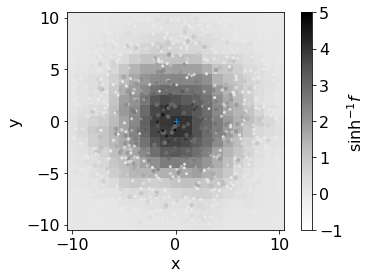

In [431]:
sampling.imshow(S_S)
plt.savefig('../tex/figures/scattered-shepard.png', dpi=300)

### Modelling the image

Relevant to some, though not all, methods of interpolation of scattered data is the idea of a model image that explains our sampled fluxes. To do so, we will define:

 * The vector of samples $\vec{f}$, of length $N$,
 * A model image $\vec{F}$, which represents a regular grid of delta functions, with a total of $M$ grid points, and
 * The kernel transformation ${\mathbf A}$, an $N\times M$ matrix.

The kernel transformation defines how each sample responds to the delta function in the model image. We can build it with successive calls to the code that generates the fluxes. Under these definitions a model $\vec{m}$ can be written as:

$$\vec{m} = {\mathbf A} \cdot \vec{f}$$

Once we have ${\mathbf A}$ we can fit the parameters in the model image $\vec{F}$.  We minimize:

$$\chi^2 = \left(\vec{m} - \vec{f}\right)\cdot {\mathbf N}^{-1} \cdot \left(\vec{m} - \vec{f}\right)$$

To find the values of $\vec{F}$ minimize $\chi^2$, we apply singular value decomposition as follows:

$${\mathbf N}^{1/2} {\mathbf A} = {\mathbf U} \cdot \Sigma \cdot {\mathbf V}^T$$

That makes the inversion of the problem easy so it is:

$$\vec{F} = {\mathbf V}\cdot\Sigma \cdot {\mathbf U}^T \cdot {\mathbf N}^{-1/2} \cdot \vec{f} $$

The covariance of this image can be calculated as:

$${\mathbf C}_F^{-1} = {\mathbf A}^T\cdot{\mathbf N}^{-1}\cdot{\mathbf A}$$


In [378]:
M = len(ygrid)
A = np.zeros((sampling.nsamples, M))
for i in np.arange(M):
    f = sampling.fluxes(xcen=xgrid[i], ycen=ygrid[i])
    A[:, i] = f.flatten()

We can create a noiseless image and perform the fit. This works great. It is very closely equivalent to a full image deconvolution.

In [152]:
(U, S, VT) = np.linalg.svd(A, full_matrices=False)
Sinv = np.zeros(len(S))
Sinv[S > 0] = 1. / S[S > 0] 
W_F = VT.T.dot(np.diag(Sinv)).dot(U.T)
S_F = W_F.dot(sampling.flux_nonoise)
S_F = S_F.reshape((nx, ny))

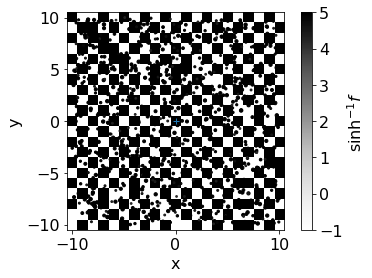

In [153]:
sampling.imshow(S_F)
plt.savefig('../tex/figures/scattered-unregularized-noiseless.png', dpi=300)

But if we add even a tiny amount of noise this runs into terrible trouble. Even $10^{-8}$ level noise leads to a very troublesome covariance matrix, which leads to strong fluctuations.

In [161]:
sampling.set_flux(total_flux=1000., noise=1.e-3)
S_F = W_F.dot(sampling.flux)
S_F = S_F.reshape((nx, ny))

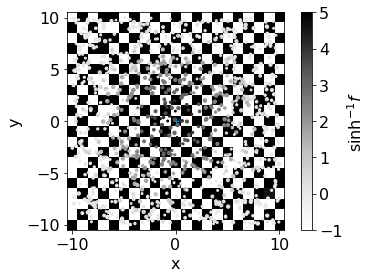

In [162]:
sampling.imshow(S_F)
plt.savefig('../tex/figures/scattered-unregularized-noisy.png', dpi=300)

The covariance matrix of this result can be calculated and clearly shows these issues.

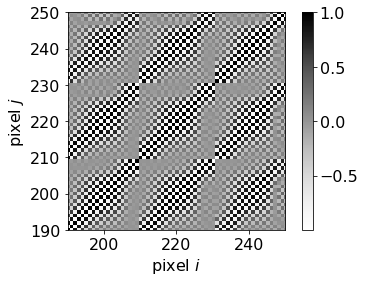

In [156]:
C_F = W_F.dot(W_F.T)
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys}
CC_F = 0. * C_F
for i in np.arange(nx * ny):
    for j in np.arange(nx * ny):
        CC_F[i, j] = C_F[i, j] / np.sqrt(C_F[i, i] * C_F[j, j])
plt.imshow(CC_F, **myargs)
nmid = (nx * ny) // 2
plt.xlim([nmid - 30, nmid + 30])
plt.ylim([nmid - 30, nmid + 30])
plt.colorbar()
plt.xlabel('pixel $i$')
plt.ylabel('pixel $j$')
plt.savefig('../tex/figures/scattered-unregularized-covar.png', dpi=300)

A very common approach to handling these issues is to regularize the fit. The simplest form of regularization is Tikhonov regularization. In its simplest form, it is designed to quadratically favor reconstruction values near zero. This case simply reduces to a conversion of the singular values that causes their inverse to smoothly go to zero below a value of $\Sigma \sim \lambda$. We can ask what this does, in the case of noise and no noise. The noiseless case is very enlightening. The PSF of this method is extremely irregular even for small values of $\lambda$.

In [157]:
llambda = 3.e-3
(U, S, VT) = np.linalg.svd(A, full_matrices=False)
Sinv = np.zeros(len(S))
Sinv = S / (S**2 + llambda**2)
W_Ts = VT.T.dot(np.diag(Sinv)).dot(U.T)
S_Ts = W_Ts.dot(sampling.flux)
S_Ts = S_Ts.reshape((nx, ny))

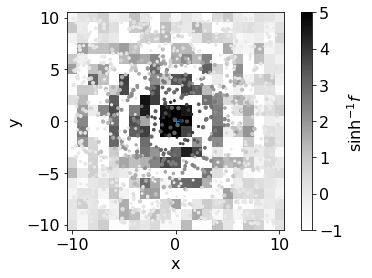

In [158]:
sampling.imshow(S_Ts)
plt.savefig('../tex/figures/scattered-regularized-simple-noisy.png', dpi=300)

In [159]:
S_Ts = W_Ts.dot(sampling.flux_nonoise)
S_Ts = S_Ts.reshape((nx, ny))

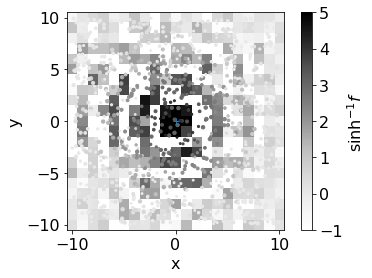

In [160]:
sampling.imshow(S_Ts)
plt.savefig('../tex/figures/scattered-regularized-simple-noiseless.png', dpi=300)

There are more complicated ways of regularizing even in the Tikhonov case. In particular, one can construct $\Gamma$ to favor minimizing the squared differences of neighboring pixels. We can solve this problem using generalized SVD. First we will test that it works on the simplest Tikhonov case. It matches perfectly.

In [115]:
N = nx * ny
Gamma = np.diag(np.ones(N))
(sigma1_gs, sigma2_gs, X_gs, U_gs, V_gs) = pygsvd.gsvd(A, Gamma, extras='uv')

In [116]:
XTinv_gs = np.linalg.inv(X_gs.T)

In [117]:
llambda = 3.e-3
sigmat_gs = np.diag(1. / (sigma1_gs * sigma1_gs + llambda**2 * sigma2_gs * sigma2_gs))
W_Tgs = XTinv_gs.dot(sigmat_gs).dot(np.diag(sigma1_gs)).dot(U_gs.T)

In [118]:
S_Tgs = W_Tgs.dot(sampling.flux_nonoise)
S_Tgs = S_Tgs.reshape((nx, ny))

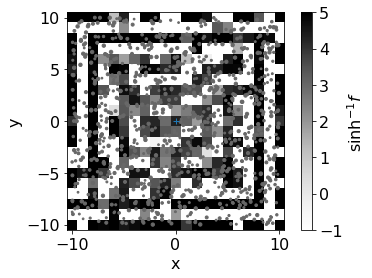

In [119]:
sampling.imshow(S_Tgs)
plt.savefig('../tex/figures/scattered-regularized-Tsimple-noiseless.png', dpi=300)

Now we construct $\Gamma$ that minimizes the squared error between neighboring pixels. This is somewhat different but also shows that the PSF for this case is a complicated beast with a lot of ringing.

In [120]:
nx = 21
ny = 21
Gamma = np.zeros((nx * ny, nx * ny))
ident = np.diag(np.ones(nx * ny)).reshape(nx, ny, nx, ny)
sident = - roll_zeropad(ident, -1, axis=2)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
sident = - roll_zeropad(ident, 1, axis=2)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
sident = - roll_zeropad(ident, -1, axis=3)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
sident = - roll_zeropad(ident, 1, axis=3)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
for indx in np.arange(nx * ny):
    Gammasum = - Gamma[indx, :].sum()
    Gamma[indx, :] = Gamma[indx, :] / Gammasum
    Gamma[indx, indx] = 1.

In [121]:
(sigma1_g, sigma2_g, X_g, U_g, V_g) = pygsvd.gsvd(A, Gamma, extras='uv')

In [122]:
XTinv_g = np.linalg.inv(X_g.T)

In [123]:
llambda = 1.e-2
sigmat_g = np.diag(1. / (sigma1_g * sigma1_g + llambda**2 * sigma2_g * sigma2_g))
W_Tg = XTinv_g.dot(sigmat_g).dot(np.diag(sigma1_g)).dot(U_g.T)

In [124]:
S_Tg = W_Tg.dot(sampling.flux_nonoise)
S_Tg = S_Tg.reshape((nx, ny))

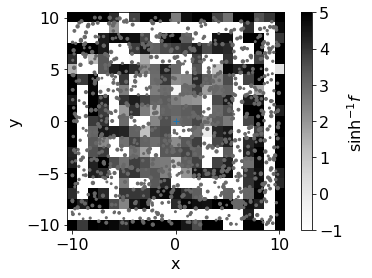

In [125]:
sampling.imshow(S_Tg)
plt.savefig('../tex/figures/scattered-regularized-T-noiseless.png', dpi=300)

In [126]:
sampling.set_flux(total_flux=1000., noise=1.e+0)

In [127]:
S_Tg = W_Tg.dot(sampling.flux)
S_Tg = S_Tg.reshape((nx, ny))

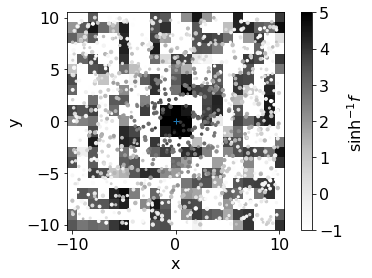

In [128]:
sampling.imshow(S_Tg)
plt.savefig('../tex/figures/scattered-regularized-T-noisy.png', dpi=300)

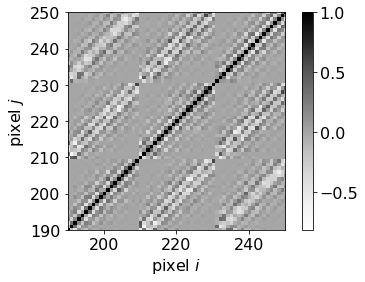

In [33]:
C_Tg = W_Tg.dot(W_Tg.T)
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys}
CC_Tg = 0. * C_Tg
for i in np.arange(nx * ny):
    for j in np.arange(nx * ny):
        CC_Tg[i, j] = C_Tg[i, j] / np.sqrt(C_Tg[i, i] * C_Tg[j, j])
plt.imshow(CC_Tg, **myargs)
nmid = (nx * ny) // 2
plt.xlim([nmid - 30, nmid + 30])
plt.ylim([nmid - 30, nmid + 30])
plt.colorbar()
plt.xlabel('pixel $i$')
plt.ylabel('pixel $j$')
plt.savefig('../tex/figures/scattered-regularized-T-covar.png', dpi=300)

## Modelling the image with nonnegative constraints

The linear problem can be solved with non-negative constraints. This choice regularizes much of the bad behavior. With no noise, the result is completely unchanged from the linear fit. Note that in this case, this result cannot be interpreted exactly as the "PSF" because the method is not linear.

In [260]:
sampling.set_flux(total_flux=100., noise=10.)

In [261]:
M = len(ygrid)
A = np.zeros((sampling.nsamples, M))
for i in np.arange(M):
    f = sampling.fluxes(xcen=xgrid[i], ycen=ygrid[i])
    A[:, i] = f.flatten()

In [262]:
flat = np.ones(A.shape[1]) * 15.
sampling.flux = sampling.flux + A.dot(flat)
sampling.flux_nonoise = sampling.flux_nonoise + A.dot(flat)

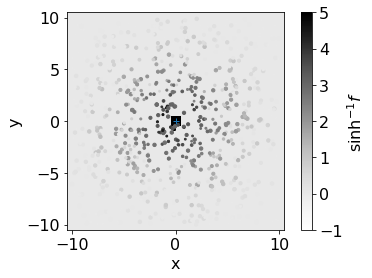

In [426]:
x = optimize.nnls(A, sampling.flux_nonoise)
S_FF = x[0].reshape(nx, ny)
sampling.imshow(S_FF)
plt.savefig('../tex/figures/scattered-nnls-noiseless.png', dpi=300)

But with noise, it still behaves pretty well! Noise spikes draw some points upwards. We expect that there will be some issues with bias of a measurement of an image derived from this method, however. For example, its total flux will be biased high. 

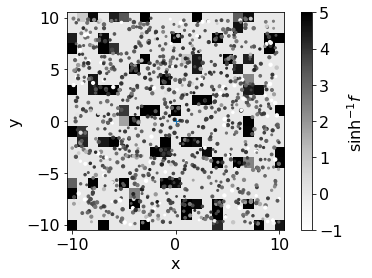

In [264]:
x = optimize.nnls(A, sampling.flux)
S_FF = x[0].reshape(nx, ny)
sampling.imshow(S_FF)
plt.savefig('../tex/figures/scattered-nnls-noisy.png', dpi=300)

In [265]:
nsample = 1000
xlo = nx // 2 - 3
xhi = nx // 2 + 3 + 1
ylo = ny // 2 - 3
yhi = ny // 2 + 3 + 1
S_FF_f = np.zeros(nsample, dtype=np.float32)
S_FF_a = np.zeros((nsample, nx, ny), dtype=np.float32)
for i in np.arange(nsample):
    sampling.set_flux(total_flux=100., noise=10.)
    sampling.flux = sampling.flux + A.dot(flat)
    sampling.flux_nonoise = sampling.flux_nonoise + A.dot(flat)
    x = optimize.nnls(A, sampling.flux)
    S_FF = x[0].reshape(nx, ny)
    S_FF_a[i, :, :] = S_FF
    S_FF_f[i] = S_FF[xlo:xhi, ylo:yhi].sum()

In [266]:
print(S_FF_f.mean())
print(S_FF_f.std())

839.86456
160.28719


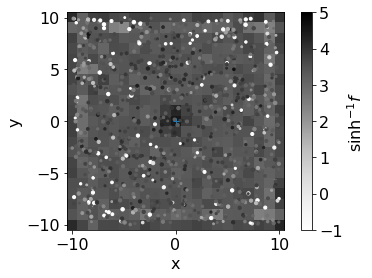

In [267]:
S_FF_m = S_FF_a.mean(axis=0)
sampling.imshow(S_FF_m)

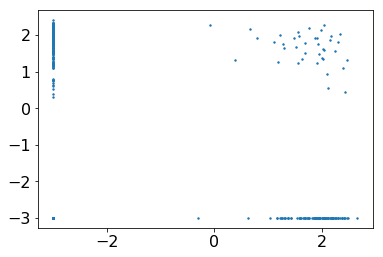

In [287]:
plt.scatter(np.log10(S_FF_a[:, 5, 5] + 1.e-3), np.log10(S_FF_a[:, 5, 6] + 1.e-3), s=2)

In [283]:
S_FF_ar = S_FF_a.reshape(nsample, nx * ny)
C_FF = np.zeros((nx * ny, nx * ny))
CS_FF = np.zeros((nx * ny, nx * ny))
for i in np.arange(nx * ny):
    for j in np.arange(nx * ny):
        C_FF[i, j] = (((S_FF_ar[:, i] - S_FF_ar[:, i].mean()) *
                       (S_FF_ar[:, j] - S_FF_ar[:, j].mean())).sum() /
                       np.float32(nsample))
        isort = np.float32(np.argsort(S_FF_ar[:, i]))
        jsort = np.float32(np.argsort(S_FF_ar[:, j]))
        CS_FF[i, j] = (((isort - isort.mean()) * (jsort - jsort.mean())).sum() /
                       np.float32(nsample))

In [ ]:
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys}
CC_FF = 0. * C_FF
CCS_FF = 0. * CS_FF
for i in np.arange(nx * ny):
    for j in np.arange(nx * ny):
        CC_FF[i, j] = C_FF[i, j] / np.sqrt(C_FF[i, i] * C_FF[j, j])
        CCS_FF[i, j] = CS_FF[i, j] / np.sqrt(CS_FF[i, i] * CS_FF[j, j])
       

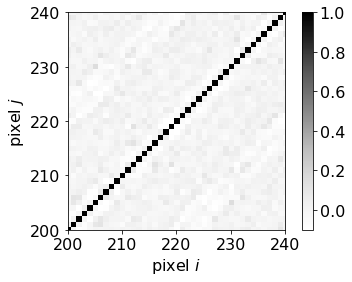

In [285]:
plt.imshow(CC_FF, vmin=-0.1, vmax=1., **myargs)
nmid = (nx * ny) // 2
plt.xlim([nmid - 20, nmid + 20])
plt.ylim([nmid - 20, nmid + 20])
plt.colorbar()
plt.xlabel('pixel $i$')
plt.ylabel('pixel $j$')
plt.savefig('../tex/figures/scattered-nnls-covar.png', dpi=300)

In [63]:
nsample = 1000
xlo = nx // 2 - 3
xhi = nx // 2 + 3 + 1
ylo = ny // 2 - 3
yhi = ny // 2 + 3 + 1
S_FF_f1 = np.zeros(nsample, dtype=np.float32)
S_FF_a1 = np.zeros((nsample, nx, ny), dtype=np.float32)
for i in np.arange(nsample):
    sampling.set_flux(total_flux=1000., noise=1., xcen=0.0, ycen=0.0)
    x = optimize.nnls(A, sampling.flux)
    S_FF = x[0].reshape(nx, ny)
    S_FF_a1[i, :, :] = S_FF
    S_FF_f1[i] = S_FF[xlo:xhi, ylo:yhi].sum()

In [64]:
nsample = 1000
xlo = nx // 2 - 3
xhi = nx // 2 + 3 + 1
ylo = ny // 2 - 3
yhi = ny // 2 + 3 + 1
S_FF_f2 = np.zeros(nsample, dtype=np.float32)
S_FF_a2 = np.zeros((nsample, nx, ny), dtype=np.float32)
for i in np.arange(nsample):
    sampling.set_flux(total_flux=1000., noise=1., xcen=1.3, ycen=0.7)
    x = optimize.nnls(A, sampling.flux)
    S_FF = x[0].reshape(nx, ny)
    S_FF_a2[i, :, :] = S_FF
    S_FF_f2[i] = S_FF[xlo:xhi, ylo:yhi].sum()

In [65]:
nsample = 1000
xlo = nx // 2 - 3
xhi = nx // 2 + 3 + 1
ylo = ny // 2 - 3
yhi = ny // 2 + 3 + 1
S_FF_f12 = np.zeros(nsample, dtype=np.float32)
S_FF_a12 = np.zeros((nsample, nx, ny), dtype=np.float32)
for i in np.arange(nsample):
    sampling.set_flux(total_flux=1000., noise=1., xcen=0.0, ycen=0.0)
    f1_nonoise = sampling.flux_nonoise
    f1 = sampling.flux
    sampling.set_flux(total_flux=1000., noise=1., xcen=1.3, ycen=0.7)
    f2_nonoise = sampling.flux_nonoise
    f2 = sampling.flux
    sampling.flux_nonoise = f1_nonoise + f2_nonoise
    sampling.flux = f1 + f2
    x = optimize.nnls(A, sampling.flux)
    S_FF = x[0].reshape(nx, ny)
    S_FF_a12[i, :, :] = S_FF
    S_FF_f12[i] = S_FF[xlo:xhi, ylo:yhi].sum()

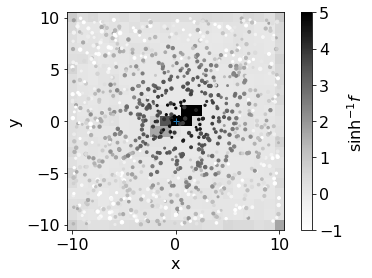

In [66]:
S_FF_m1 = S_FF_a1.mean(axis=0)
S_FF_m2 = S_FF_a2.mean(axis=0)
S_FF_m12 = S_FF_a12.mean(axis=0)
sampling.imshow(S_FF_m12)

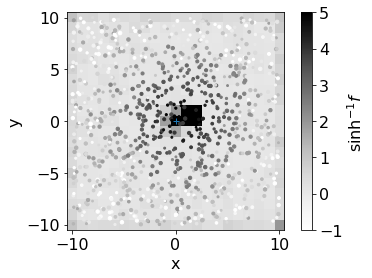

In [67]:
sampling.imshow(S_FF_m1 + S_FF_m2)

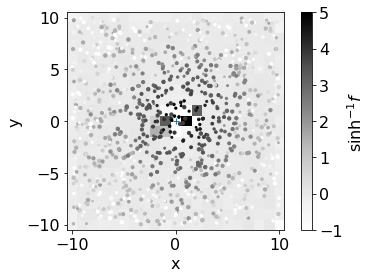

In [68]:
sampling.imshow(S_FF_m12 - (S_FF_m1 + S_FF_m2))

Calculating covar

In [118]:
import scipy.sparse as sparse
import sparsesvd

class Reconstruct(object):
    def __init__(self, fmin=1.e-10):
        self.fmin = fmin
        self.flag_low_coverage = 1
        self.flag_unconstrained = 2
        return
    
    def set_A(self, A=None):
        self.A = A
        self.N = self.A.shape[0] # number of samples
        self.M = self.A.shape[1] # number of reconstruction points
        self.flag = np.zeros(self.M, dtype=np.int32)
        return
    
    def set_Asparse(self):
        # Find very unconstrained reconstruction points
        Asumcol = self.A.sum(axis=0)
        ic = np.where(Asumcol < self.A.max() * self.fmin)[0]
        self.flag[ic] = np.bitwise_or(self.flag[ic], self.flag_low_coverage)
        
        # Set up trimmed version of A
        self.iAtrim = np.where(self.flag == 0)[0]
        Atrim = self.A[:, self.iAtrim]
       
        # Set explicitly to zero any very low contributions to a sample
        Amaxrow = Atrim.max(axis=1)
        for irow in np.arange(self.N, dtype=np.int32):
            ilow = np.where(Atrim[irow, :] < Amaxrow[irow] * self.fmin)[0]
            Atrim[irow, ilow] = 0.
        
        self.Asparse = sparse.csc_matrix(Atrim, dtype=np.float64)
        return
    
    def set_weights(self):
        (UT, S, VT) = sparsesvd.sparsesvd(self.Asparse, self.M)
        
        iSzero = np.where(S < S.max() * self.fmin)[0]
        self.iSnotzero = np.where(S >= S.max() * self.fmin)[0]
        self.flag[iSzero] = self.flag_unconstrained
        
        Snotzero = S[self.iSnotzero]
        Q = VT.T[:, self.iSnotzero].dot(np.diag(Snotzero)).dot(UT[self.iSnotzero, :])
        Qs = Q.sum(axis=1)
        self.Wc = np.diag(1. / Qs).dot(VT.T[:, self.iSnotzero]).dot(UT[self.iSnotzero, :])
        return
    
    def apply_weights(self, samples=None):
        pixels = np.zeros(self.M, dtype=np.float64)
        pixels[self.iAtrim] = self.Wc.dot(samples)
        return(pixels)
        

In [119]:
r = Reconstruct()
r.set_A(A=A)
r.set_Asparse()

In [120]:
r.set_weights()

In [122]:
pix = r.apply_weights(samples=sampling.flux_nonoise)

<IPython.core.display.Javascript object>


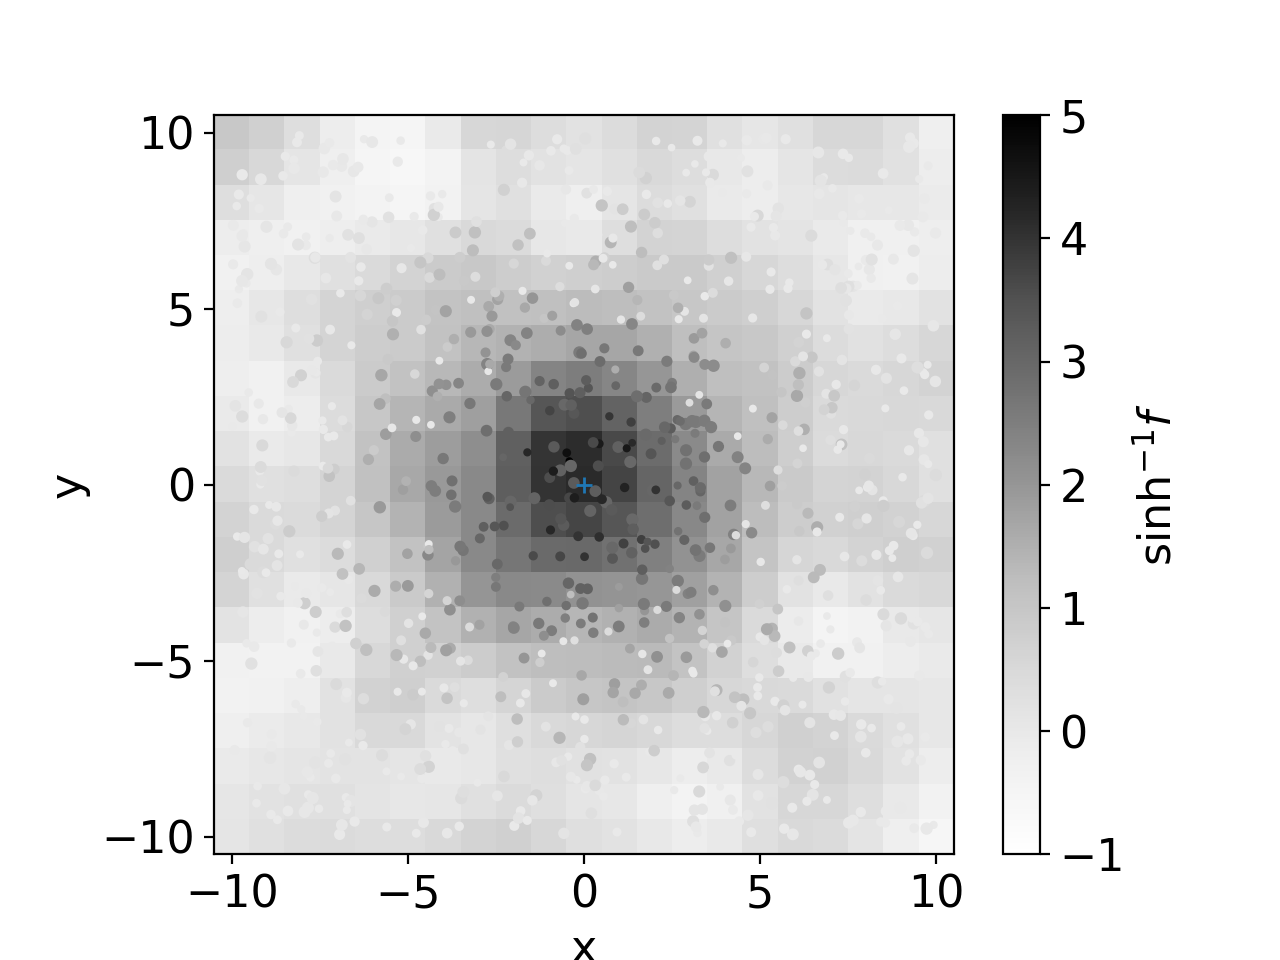

In [123]:
pixshow = pix.reshape(nx, ny)
sampling.imshow(pixshow)
plt.savefig('../tex/figures/scattered-G-noisy.png', dpi=300)

<IPython.core.display.Javascript object>


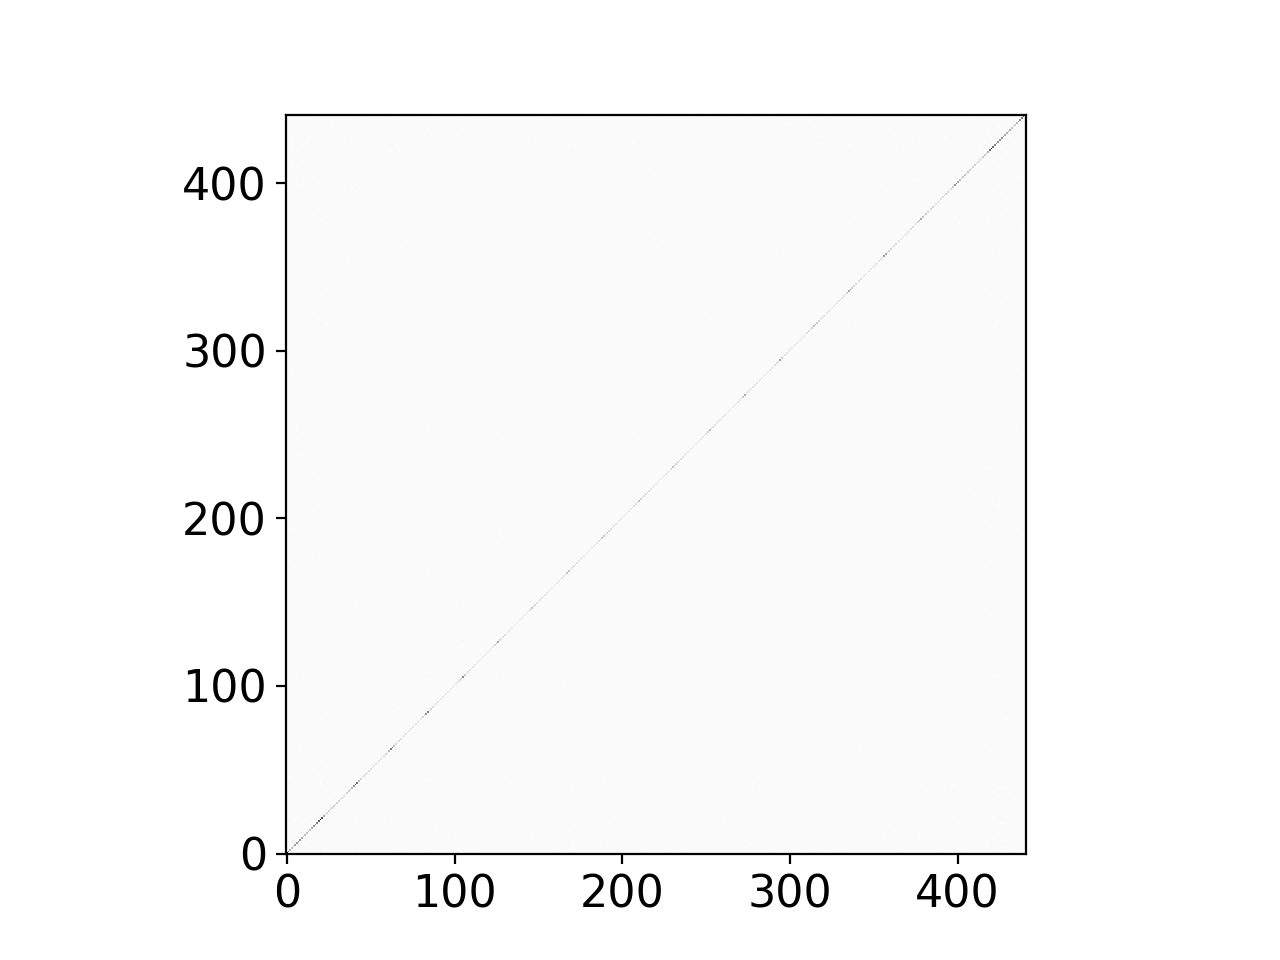

In [124]:
C = r.Wc.dot(r.Wc.T)
plt.imshow(np.arcsinh(C), **myargs)

In [88]:
print(A.shape)

(50, 441)


### Richardson-Lucy 

Richardson-Lucy deconvolves by iterating on the following equations:

$$\vec{c}^{(k)} = \mathbf{A}\cdot \vec{S}_R^{(k)}$$

$$d^{(k)}_i = \frac{f_i}{c_i^{(k)}}$$

$${S}_{R,i}^{(k+1)} = {S}_{R,i}^{(k)} \left(\mathbf{A}^T \cdot \vec{d}^{(k)}\right)_i$$

In [530]:
sampling = Sampling(nsamples=1000, sigmarange=[0.5, 1.])
sampling.set_flux(total_flux=1000., noise=1.e-3)

In [531]:
M = len(ygrid)
A = np.zeros((sampling.nsamples, M))
for i in np.arange(M):
    f = sampling.fluxes(xcen=xgrid[i], ycen=ygrid[i])
    A[:, i] = f.flatten()

In [532]:
S_0 = np.ones(A.shape[1]) * 0.

In [544]:
flux = sampling.flux_nonoise
flux_fit = flux.copy()
flux_fit = flux_fit # + A.dot(S_0)
S_R = S_R.flatten()  # * 0. + 1000.
# S_R[10 + 21 * 10] = 1000.
for i in np.arange(5000):
    c = A.dot(S_R) # + A.dot(S_0)
    d = flux_fit / c
    S_R = S_R * (A.T.dot(d))
S_R = S_R.reshape((nx, ny))

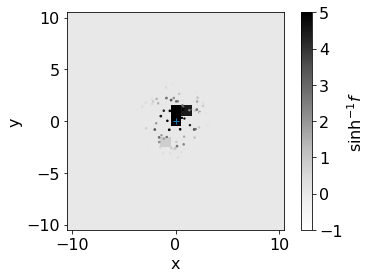

In [545]:
# S_R = np.zeros(len(S_S.flatten()))
# S_R[10 + 10 * 21] = 1000.
sampling.imshow(S_R.reshape((nx, ny)))

In [546]:
print(flux_fit.min())

2.0494007531806978e-148


In [573]:
import scipy.optimize as optimize

def mem_function(u, A, f, llambda):
    Ar = (A.dot(u) - f)
    As = (Ar**2).sum()
    Bs = (u * np.log(u)).sum()
    val =  As + llambda * Bs
    grad = 2. * A.T.dot(Ar) + llambda * (1. + np.log(u))
    return (val, grad)

sampling = Sampling(nsamples=1000)
sampling.set_flux(total_flux=1000., noise=1.)
f1 = sampling.flux
f1_nonoise = sampling.flux_nonoise

sampling.set_flux(total_flux=1000., noise=1., xcen=0.5, ycen=1.3)
f2 = sampling.flux
f2_nonoise = sampling.flux_nonoise

M = len(ygrid)
A = np.zeros((sampling.nsamples, M))
for i in np.arange(M):
    f = sampling.fluxes(xcen=xgrid[i], ycen=ygrid[i])
    A[:, i] = f.flatten()

sampling.flux = f1
sampling.flux_nonoise = f1_nonoise

llambda = 1.e-4
S_M0 = S_S.flatten()
S_M0[S_M0 <= 0.] = 1.e-3
bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
bounds = [x for x in bounds]

results = optimize.minimize(mem_function, S_M0, args=(A, sampling.flux_nonoise, llambda),
                            method='L-BFGS-B', jac=True,
                            bounds=bounds) 

S_M_1 = results.x.reshape(nx, ny)

In [610]:
sampling.flux = f2
sampling.flux_nonoise = f2_nonoise

In [611]:
llambda = 1.e-4
S_M0 = S_S.flatten()
S_M0[S_M0 <= 0.] = 1.e-3
bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
bounds = [x for x in bounds]

results = optimize.minimize(mem_function, S_M0, args=(A, sampling.flux_nonoise, llambda),
                            method='L-BFGS-B', jac=True,
                            bounds=bounds) 

S_M_2 = results.x.reshape(nx, ny)

In [612]:
sampling.flux = f1 + f2
sampling.flux_nonoise = f1_nonoise + f2_nonoise

In [613]:
llambda = 1.e-4
S_M0 = S_S.flatten()
S_M0[S_M0 <= 0.] = 1.e-3
bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
bounds = [x for x in bounds]

results = optimize.minimize(mem_function, S_M0, args=(A, sampling.flux_nonoise, llambda),
                            method='L-BFGS-B', jac=True,
                            bounds=bounds) 

S_M_12 = results.x.reshape(nx, ny)

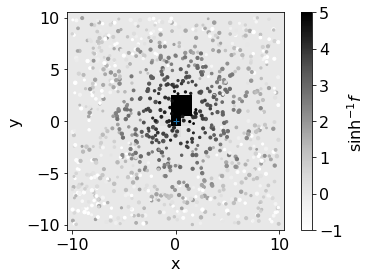

In [614]:
sampling.imshow(S_M_2 + S_M_1)

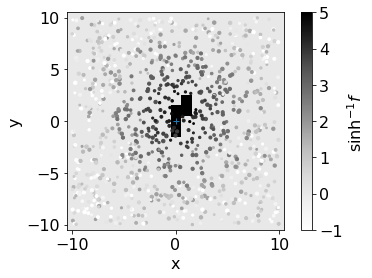

In [615]:
sampling.imshow(S_M_12)

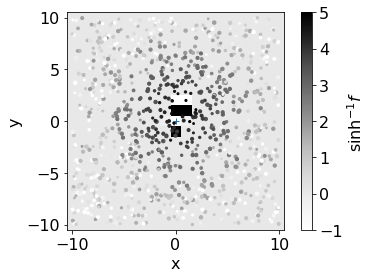

In [616]:
sampling.imshow(S_M_12 - S_M_1 - S_M_2)

In [639]:
flat = np.ones(A.shape[1]) * 100.

In [640]:
sampling.flux = sampling.flux * 0. + A.dot(flat) + np.random.normal(size=len(sampling.flux)) * 5
sampling.flux_nonoise = sampling.flux * 0. + A.dot(flat)

In [645]:
llambda = 1.e-2
S_M0 = S_S.flatten()
S_M0[S_M0 <= 0.] = 1.e-3
bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
bounds = [x for x in bounds]

results = optimize.minimize(mem_function, S_M0, args=(A, sampling.flux, llambda),
                            method='L-BFGS-B', jac=True,
                            bounds=bounds) 

S_M_flat = results.x.reshape(nx, ny)

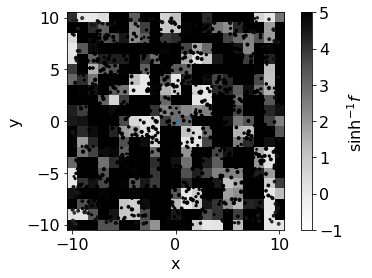

In [646]:
sampling.imshow(S_M_flat)

In [626]:
nsample = 1000
S_M_arr = np.zeros((nsample, nx, ny)) 
llambda = 1.e-4
for i in np.arange(nsample):
    sampling.set_flux(total_flux=0., noise=1.)
    sampling.flux = sampling.flux + A.dot(flat)
    S_M0 = S_S.flatten()
    S_M0[S_M0 <= 0.] = 1.e-3
    bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
    bounds = [x for x in bounds]
    results = optimize.minimize(mem_function, S_M0, args=(A, sampling.flux, llambda),
                                method='L-BFGS-B', jac=True,
                                bounds=bounds) 
    S_M_arr[i, :, :] = results.x.reshape(nx, ny)

KeyboardInterrupt: 

In [621]:
S_M_arr1d = S_M_arr.reshape(nsample, nx * ny)
C_M = np.zeros((nx * ny, nx * ny))
for i in np.arange(nx * ny):
    for j in np.arange(nx * ny):
        C_M[i, j] = (((S_M_arr1d[:, i] - S_M_arr1d[:, i].mean()) *
                      (S_M_arr1d[:, j] - S_M_arr1d[:, j].mean())).sum() /
                       np.float32(nsample))

In [622]:
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys}
CC_M = 0. * C_M
for i in np.arange(nx * ny):
    for j in np.arange(nx * ny):
        CC_M[i, j] = C_M[i, j] / np.sqrt(C_M[i, i] * C_M[j, j])
       

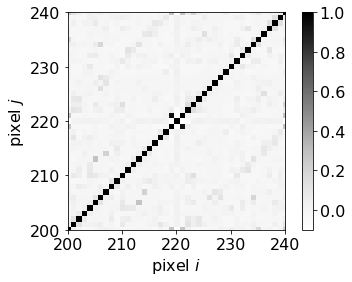

In [624]:
plt.imshow(CC_M, vmin=-0.1, vmax=1., **myargs)
nmid = (nx * ny) // 2
plt.xlim([nmid - 20, nmid + 20])
plt.ylim([nmid - 20, nmid + 20])
plt.colorbar()
plt.xlabel('pixel $i$')
plt.ylabel('pixel $j$')
plt.savefig('../tex/figures/scattered-nnls-covar.png', dpi=300)

In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=10), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)